# Data Visualization Notebook

1st public version: Created on May 6th, 2020.  
2nd public version: Created on May 7th, 2020.  
3rd public version: Created on May 10th, 2020.  

안녕하세요, 여러분.  
저는 이 competition ** M5 -accuracy- ** 도전자 중 한명입니다.  
저는 테스트 데이터셋을 예측하기 위해 몇몇의 유용한 insight를 알고 싶습니다.

여기서 저는 특히 저 같은 초보자들을 위한 데이터 시각화를 위한 노트북을 만들었습니다.  
저는 여러분들의 조회와 댓글 모두 감사합니다.

https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration   
이 노트북은 정말 좋습니다.  
만약 여러분들이 시간이 있다면, 저는 한 번 보는 것을 강력 추천합니다.  
그리고 저는 Reference 섹션에서 다른 좋은 커널들을 소개할 것입니다.  


<!--

Hello, everyone.  
I'm one of the challenger of this competition **M5 -accuracy- **.  
I'd like to find some useful insights for predictiong the test dataset.  

Here I created a notebook for data visualization especially for beginners like me.  
I appreciate all of your views and comments.

https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration  
His notebook is super great.  
If you have time, I strongly recommend you to take a look.
And I'll introduce other good kernels in Reference Section
-->

Here is table of contents in this notebook:
- [Import Libraries and Data Input](#Import-Libraries-and-Data-Input)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
   -  [Total Item Sold Transition](#Total-Item-Sold-Transition)
   -  [Item Sold in each day type](#Item-Sold-in-each-day-type)
   -  [Item sold in each State and Store](#Item-sold-in-each-State-and-Store)
   -  [Item Sold relation Analysis](#Item-Sold-relation-Analysis)
   -  [Store Analysis](#Store-Analysis)
   -  [Snap Purchase Analysis](#Snap-Purchase-Analysis)
   -  [Event Pattern Analysis](#Event-Pattern-Analysis)
   -  [One Item Features Analysis](#One-Item-Features-Analysis)
   -  [Sell Price Analysis](#Sell-Price-Analysis)
   -  [Sell price and value relationship](#Sell-price-and-value-relationship)
   -  [Relationship of Lag Variables](#Relationship-of-Lag-Variables)
   -  [PCA Trial](#PCA-Trial)
  
- [Summary](#Summary)
- [Future Work](#Future-Work)
- [References](#References)

# Import Libraries and Data Input

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import time
# import datetime
# import xgboost as xgb
# import time
# import itertools
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

%matplotlib inline
sns.set()

In [3]:
INPUT_DIR = '/kaggle/input/m5-forecasting-accuracy'

calendar_df = pd.read_csv(f"{INPUT_DIR}/calendar.csv")
sell_prices_df = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv")
sales_train_validation_df = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv")
sample_submission_df = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv")

> 메모리 사용 감소를 위해
>
> calendar 관련 숫자 데이터들을 숫자 타입으로 변경 
>
> calendar 관련 문자 데이터들을 category 타입으로 변경 

In [4]:
# Calendar data type cast -> Memory Usage Reduction
calendar_df[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]] = calendar_df[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]].astype("int8")
calendar_df[["wm_yr_wk", "year"]] = calendar_df[["wm_yr_wk", "year"]].astype("int16") 
calendar_df["date"] = calendar_df["date"].astype("datetime64")

nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    calendar_df[feature].fillna('unknown', inplace = True)

calendar_df[["weekday", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] = calendar_df[["weekday", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] .astype("category")

> 메모리 사용 감소를 위해
>
> 숫자 타입으로 변경

In [5]:
# Sales Training dataset cast -> Memory Usage Reduction
sales_train_validation_df.loc[:, "d_1":] = sales_train_validation_df.loc[:, "d_1":].astype("int16")

> sell_price 에 ID 컬럼 생성

In [6]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
# Make ID column to sell_price dataframe
sell_prices_df.loc[:, "id"] = sell_prices_df.loc[:, "item_id"] + "_" + sell_prices_df.loc[:, "store_id"] + "_validation"

In [8]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price,id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1_validation
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1_validation
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1_validation
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1_validation
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1_validation


In [9]:
sell_prices_df = pd.concat([sell_prices_df, sell_prices_df["item_id"].str.split("_", expand=True)], axis=1)
sell_prices_df = sell_prices_df.rename(columns={0:"cat_id", 1:"dept_id"})
sell_prices_df[["store_id", "item_id", "cat_id", "dept_id"]] = sell_prices_df[["store_id","item_id", "cat_id", "dept_id"]].astype("category")
sell_prices_df = sell_prices_df.drop(columns=2)

In [10]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price,id,cat_id,dept_id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1_validation,HOBBIES,1
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1_validation,HOBBIES,1
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1_validation,HOBBIES,1
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1_validation,HOBBIES,1
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1_validation,HOBBIES,1


# Data Cleaning
먼저, 모든 3개의 데이터 프레임을 합쳐봅시다.  
중요한 것은 모델을 더 쉽게 예측하기 위해 데이터 포맷을 넓은 것에서 긴 것으로 바꾸는 것입니다.  
(이 노트북은 예측 모델 자체를 다루지는 않습니다.)

<!--
First, let's combine all three dataframe.  
The important thing is changing data format from wide to long to make prediction model easier  
(Though this notebook doesn't dive into predicition model itself.)
-->


In [11]:
def make_dataframe():
    # Wide format dataset 
    df_wide_train = sales_train_validation_df.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T
    df_wide_train.index = calendar_df["date"][:1913]
    df_wide_train.columns = sales_train_validation_df["id"]
    
    # Making test label dataset
    df_wide_test = pd.DataFrame(np.zeros(shape=(56, len(df_wide_train.columns))), index=calendar_df.date[1913:], columns=df_wide_train.columns)
    df_wide = pd.concat([df_wide_train, df_wide_test])

    # Convert wide format to long format
    df_long = df_wide.stack().reset_index(1)
    df_long.columns = ["id", "value"]

    del df_wide_train, df_wide_test, df_wide
    gc.collect()
    
    df = pd.merge(pd.merge(df_long.reset_index(), calendar_df, on="date"), sell_prices_df, on=["id", "wm_yr_wk"])
    df = df.drop(columns=["d"])
#     df[["cat_id", "store_id", "item_id", "id", "dept_id"]] = df[["cat_id"", store_id", "item_id", "id", "dept_id"]].astype("category")
    df["sell_price"] = df["sell_price"].astype("float16")   
    df["value"] = df["value"].astype("int32")
    df["state_id"] = df["store_id"].str[:2].astype("category")


    del df_long
    gc.collect()

    return df

df = make_dataframe()

In [12]:
df.dtypes

date            datetime64[ns]
id                      object
value                    int32
wm_yr_wk                 int16
weekday               category
wday                      int8
month                     int8
year                     int16
event_name_1          category
event_type_1          category
event_name_2          category
event_type_2          category
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
store_id              category
item_id               category
sell_price             float16
cat_id                category
dept_id               category
state_id              category
dtype: object

In [13]:
def add_date_feature(df):
    df["year"] = df["date"].dt.year.astype("int16")
    df["month"] = df["date"].dt.month.astype("int8")
    df["week"] = df["date"].dt.week.astype("int8")
    df["day"] = df["date"].dt.day.astype("int8")
    df["quarter"]  = df["date"].dt.quarter.astype("int8")
    return df

In [14]:
df = add_date_feature(df)
df

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_WI,store_id,item_id,sell_price,cat_id,dept_id,state_id,week,day,quarter
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,4,29,1
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,4,30,1
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,31,1
3,2011-02-01,HOBBIES_1_008_CA_1_validation,0,11101,Tuesday,4,2,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,1,1
4,2011-02-02,HOBBIES_1_008_CA_1_validation,0,11101,Wednesday,5,2,2011,unknown,unknown,...,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,2016-06-19,FOODS_3_825_WI_3_validation,0,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,...,0,WI_3,FOODS_3_825,3.980469,FOODS,3,WI,24,19,2
47735393,2016-06-18,FOODS_3_826_WI_3_validation,0,11621,Saturday,1,6,2016,unknown,unknown,...,0,WI_3,FOODS_3_826,1.280273,FOODS,3,WI,24,18,2
47735394,2016-06-19,FOODS_3_826_WI_3_validation,0,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,...,0,WI_3,FOODS_3_826,1.280273,FOODS,3,WI,24,19,2
47735395,2016-06-18,FOODS_3_827_WI_3_validation,0,11621,Saturday,1,6,2016,unknown,unknown,...,0,WI_3,FOODS_3_827,1.000000,FOODS,3,WI,24,18,2


# Data Visualization
## Total Item Sold Transition

In [15]:
temp_series = df.groupby(["cat_id", "date"])["value"].sum()
temp_series

cat_id     date      
FOODS      2011-01-29    23178
           2011-01-30    22758
           2011-01-31    17174
           2011-02-01    18878
           2011-02-02    14603
                         ...  
HOUSEHOLD  2016-06-15        0
           2016-06-16        0
           2016-06-17        0
           2016-06-18        0
           2016-06-19        0
Name: value, Length: 5907, dtype: int32

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


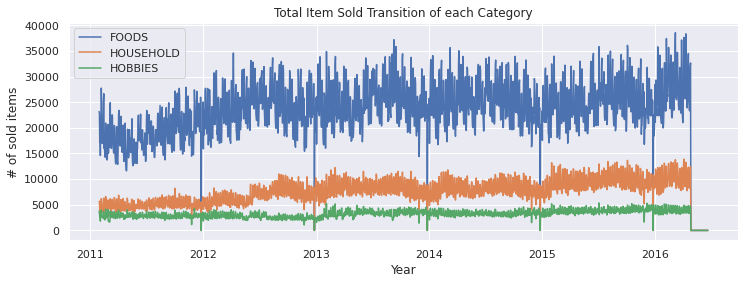

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Category")
plt.legend()


**Point of the graph**

1. FOODS는 이 3개의 카테고리 중에서 가장 많이 팔린 품목 카테고리이다.  
   HOUSEHOLD는 2번째이고, HOBBIES는 가장 적게 팔린 품목이다.
   
2. FOODS 카테고리는 분명히 몇몇의 주기적인 특성을 갖고 있다.  
   일년 동안, 이것은 겨울보다 여름에 더 많이 팔린 것으로 보인다. 그러나, 이것을 검증해봐야한다.

3. HOUSEHOLD 카테고리 품목의 판매량은 2011년부터 점점 증가했다.  
   그러나, 2011년에 상점에 몇몇 품목이 없었기 때문일 지도 모른다.  
   그래서 우리는 상점에서의 총 품목을 고려해봐야 한다.  
   주기적인 특성은 FOODS와 비교해서 이 카테고리에서는 그렇게 분명하지는 않다.

4. HOBBIES 카테고리에선, 주기적 특성이 HOUSEHOLD 카테고리처럼 분명하지 않다.  

5. 몇몇 부분에서 (연말 쯤), 모든 카테고리들은 어떤 판매도 없다. 그래서 나는 훈련 모델에서 이런 날들을 가져왔는 지 고려해봐야 한다고 생각한다.

자, 가장 최근인 2015년을 보자!

<!--
1. FOODS is the most sold item category of these three categories.  
   HOUSEHOLD is the 2nd one, and HOBBIES are the least sold one.  


2. FOODS category appearently has some periodical feature.   
   During one year, it seems more items are sold in summer than in winter, however, we have to verify this.  
   As for more short time interval, it seems the trend has monthly or weekly features. (Let's take a look below)

3. HOUSEHOLD category items sold is gradually increasing from 2011.  
   However, it may be because some items are not in the store in 2011.  
   So we have to take the total item in the store into account.
   Periodical Features are not so clear in this category compared to FOODS.
  
4. In HOBBIES category, periodical features are less appearent like HOUSEHOLD category.

5. In some point (around the end of year), all categories don't have any sold.  So I think we have to consider whether we take these days into account when training models.

So let's take a look at the latest year, 2015!
-->

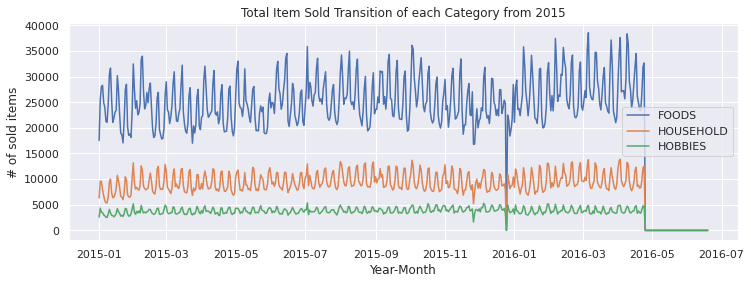

In [17]:
temp_series = temp_series.loc[temp_series.index.get_level_values("date") >= "2015-01-01"]
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year-Month")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Category from 2015")
plt.legend()

1. 모든 카테고리에서, 주기적 추세는 주별로 보여진다.  
   이전 그래프에선, 우리는 쉽게 HOUSEHOLD와 HOBBIES가 주간 특성을 인식할 수 없었으나, 이 그래프에선느 할 수 있다.
   
2. 모든 품목이 판매된 양이 0인 날은 크리스마스 처럼 보인다. 신년은 아니라는 것은 밑에서 확인하자.

<!--
1. In all categories, the periodical trends is seemed weekly.  
   In previous graph, we can't easily recognize that HOUSEHOLD and HOBBIES have weekly features, but in this graph we can.
   
2. The day when all item sold is 0 is seemed to be Christmas Day, not new year's day, confirm it below.
-->

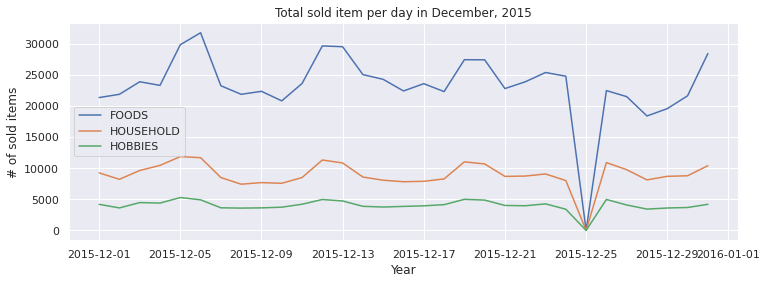

In [18]:
# Plot only December, 2015
temp_series = temp_series.loc[(temp_series.index.get_level_values("date") >= "2015-12-01") & (temp_series.index.get_level_values("date") <= "2015-12-31")]
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total sold item per day in December, 2015")
plt.legend()

크리스마스에 판매된 품목이 0처럼 보인다. *.loc* 함수로 확인해보자.

<!--
On Christmas Day, the items sold are seemed to be 0, let's check it with *.loc* method
-->

In [19]:
temp_series.loc[(temp_series.index.get_level_values("date") >= "2015-12-24") & (temp_series.index.get_level_values("date") <= "2015-12-26")]

cat_id     date      
FOODS      2015-12-24    24801
           2015-12-25       13
           2015-12-26    22488
HOBBIES    2015-12-24     3408
           2015-12-25        0
           2015-12-26     4977
HOUSEHOLD  2015-12-24     8018
           2015-12-25        1
           2015-12-26    10912
Name: value, dtype: int32

몇몇의 품목은 심지어 크리스마스에도 팔렸다. 그러나 나는 noisy된 값이 있다고 완전히 생각한다.

지금까지, 우리는 판매된 품목이 주간 특징을 가지고 있다는 것을 알 수 있었다. 이것을 생각해보자:
**다음 질문: 그 주의 어느 날에 가장 많이 판매될까?**

<!--
Some items are sold even on Christmas Day, but I think these are completely noisy values.   

Until now, we can find the items sold have something weekly fetures. So let's think this:   
**Next Question: Which day of the week is the items sold most?**
-->

## Item Sold in each day type

In [20]:
temp_series = df.groupby(["cat_id", "wday"])["value"].sum()
temp_series

cat_id     wday
FOODS      1       7693153
           2       7767048
           3       6206765
           4       5736838
           5       5651175
           6       5683848
           7       6351112
HOBBIES    1       1076911
           2        976586
           3        813632
           4        777821
           5        786310
           6        786135
           7        907405
HOUSEHOLD  1       2613785
           2       2525992
           3       1948463
           4       1776018
           5       1755251
           6       1775984
           7       2085177
Name: value, dtype: int32

Text(0.5, 1.0, 'Total sold item in each daytype')

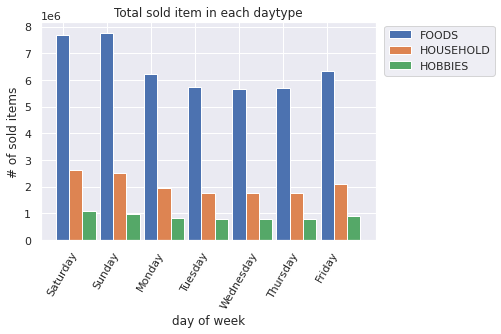

In [21]:
plt.figure(figsize=(6, 4))
left = np.arange(1,8) 
width = 0.3
weeklabel = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]    # Please Confirm df


plt.bar(left, temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, width=width, label="FOODS")
plt.bar(left + width, temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, width=width, label="HOUSEHOLD")
plt.bar(left + width + width, temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, width=width, label="HOBBIES")
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.xticks(left, weeklabel, rotation=60)
plt.xlabel("day of week")
plt.ylabel("# of sold items")
plt.title("Total sold item in each daytype")

1. 우리가 추측할 수 있는 것처럼, 토요일이나 일요일이 가장 많이 팔린 날이다.  
   화요일과 수요일은 가장 적게 팔린 날이다.  
   -> 나중에, 우리는 이런 관계 요소를 히트맵으로 시각화할 것이다. 다음을 보자!

2. HOBBIES가 FOODS나 HOUSEHOLD와 비교해서 날짜에 그렇게 의존적이지는 않다.

<!--
1. As we can probraly guess, Saturday or Sunday is the day which the items are most sold.  
   Tuesday or Wednesday is the least sold days.  
   -> Later, we visualize these correlation factors with heatmap. Looking forward to it!

2. HOBBIES are not so day dependent compared to FOODS or HOUSEHOLD.  
-->

## Item sold in each State and Store

In [22]:
temp_series = df.groupby(["state_id", "date"])["value"].sum()
temp_series

state_id  date      
CA        2011-01-29    14195
          2011-01-30    13805
          2011-01-31    10108
          2011-02-01    11047
          2011-02-02     9925
                        ...  
WI        2016-06-15        0
          2016-06-16        0
          2016-06-17        0
          2016-06-18        0
          2016-06-19        0
Name: value, Length: 5907, dtype: int32

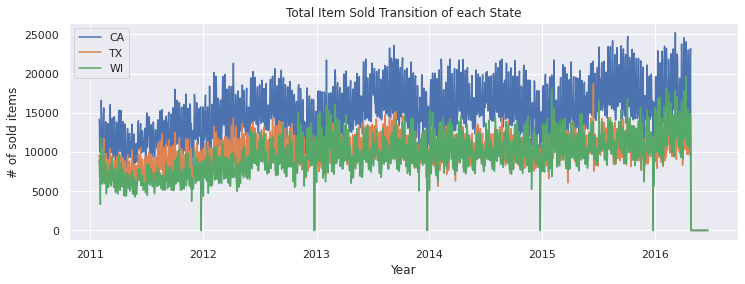

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("state_id") == "CA"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("state_id") == "CA"].values, label="CA")
plt.plot(temp_series[temp_series.index.get_level_values("state_id") == "TX"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("state_id") == "TX"].values, label="TX")
plt.plot(temp_series[temp_series.index.get_level_values("state_id") == "WI"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("state_id") == "WI"].values, label="WI")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each State")
plt.legend()

1. CA는 3개의 주 중에서 가장 많이 팔린 주이다.
   TX와 WI는 2011년과 2012년을 제외하곤 엄청 다르지는 않다.

2. 모든 3개의 주는 카테고리 기반의 품목 판매 그래프에서 이미 본 것처럼 일부 주기적인 특징이 있다.

먼저, CA에서의 상점을 보자.

<!--
1. CA is the most sold state of these three states.  
   TX and WI are not so different except for the year 2011 and 2012.
  
2. All three states have some periodical features as we've already seen in category-based item sold graph. 

First, let's focus on stores in CA.
-->

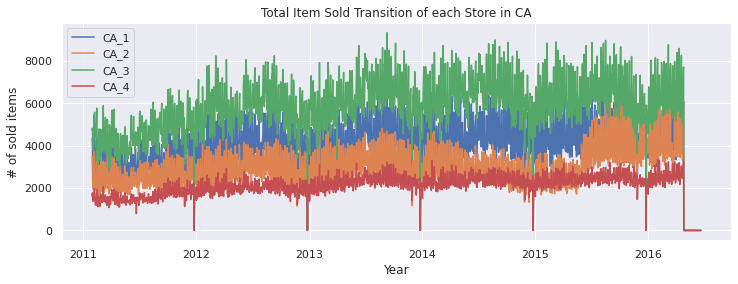

In [24]:
temp_series = df.groupby(["store_id", "date"])["value"].sum()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].values, label="CA_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].values, label="CA_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].values, label="CA_3")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].values, label="CA_4")

plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Store in CA")
plt.legend()

1. CA 에서의 3개의 상점은 상품의 판매 기록이 비슷하다.
   CA_3은 다른 상점과 비교해서 약간 더 많은 양을 판매했다.

2. 각각의 상점의 표준 편차는 다른 것 같다. 나중에 확인해보자.

3. 2015년 봄/여름쯤부터, CA_2의 판매 기록이 빠르게 증가했다. 우리는 이유를 조사해야한다.

<!--
1. Three stores in CA have similar amount of item sold record.  
   CA_3 has more item sold a little bit compared to others.  

2. The standard deviation of each store seems different, confirm it later.

3. From around 2015 Spring or Summer, CA_2 increased its sold record rapidly. We have to investigate the reasons.
-->

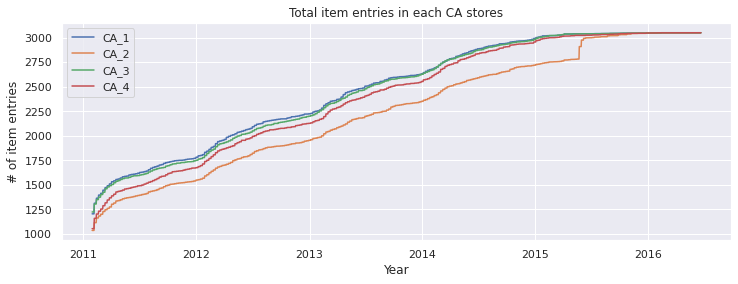

In [25]:
temp_series = df.groupby(["store_id", "date"])["item_id"].count()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].values, label="CA_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].values, label="CA_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].values, label="CA_3")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].values, label="CA_4")
plt.xlabel("Year")
plt.ylabel("# of item entries")
plt.title("Total item entries in each CA stores")
plt.legend()

3. 2015년 봄/여름쯤부터, CA_2의 판매 기록이 빠르게 증가했다. 우리는 이유를 조사해야한다.

-> 이것은 CA_2에 등록된 상품이 빠르게 증가했기 때문이다.  
2015년 여름 이후에, CA의 모든 상점들이 상품의 양을 비슷하게 등록했다.

<!--
3. From around 2015 Spring or Summer, CA_2 increased its sold record rapidly. We have to investigate the reasons.

-> It is because item registered in CA_2 increased rapidly.  
After summer in 2015, all stores in CA have similar registered item count
-->

In [26]:
temp_series = df.groupby(["store_id", "date"])["value"].std()
temp_series

store_id  date      
CA_1      2011-01-29     8.051911
          2011-01-30    10.231977
          2011-01-31     5.460182
          2011-02-01     7.009885
          2011-02-02     5.811179
                          ...    
WI_3      2016-06-15     0.000000
          2016-06-16     0.000000
          2016-06-17     0.000000
          2016-06-18     0.000000
          2016-06-19     0.000000
Name: value, Length: 19690, dtype: float64

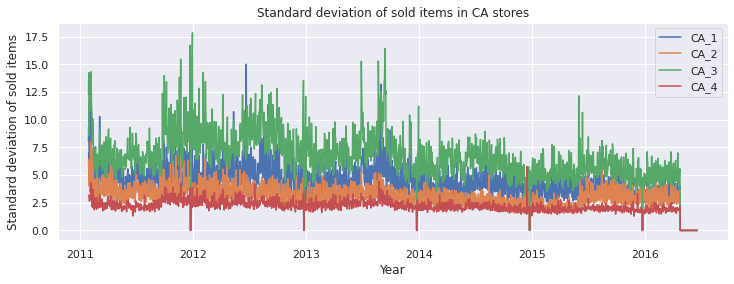

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].values, label="CA_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].values, label="CA_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].values, label="CA_3")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].values, label="CA_4")

plt.xlabel("Year")
plt.ylabel("Standard deviation of sold items")
plt.title("Standard deviation of sold items in CA stores")
plt.legend()

1. CA_3 은 CA에서 가장 많이 팔린 상점이 된 이후로, 이 상점의 표준 편차도 다른 곳에 비해 더 높다.  
   특히, 2011년 말에 판매된 상품 편차가 평소보다 더 높았다.

다른 주들을 확인해보자, 다음은 WI!

<!--
1. Since CA_3 is the most sold store in CA, standard deviation of this store is also higher than others.  
   Expecially, around the end of 2011, sold item deviation gets higher than usual. 
   
Let's check other state, WI next!
-->

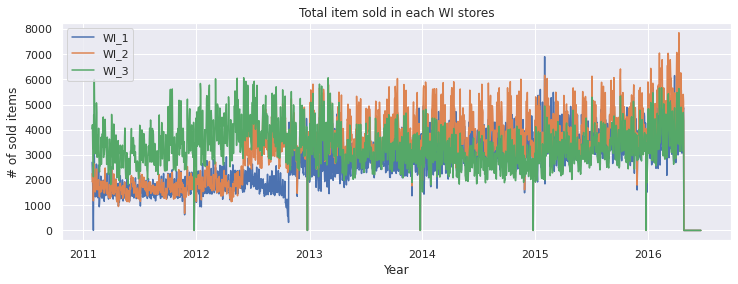

In [28]:
temp_series = df.groupby(["store_id", "date"])["value"].sum()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_1"].values, label="WI_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_2"].values, label="WI_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_3"].values, label="WI_3")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total item sold in each WI stores")
plt.legend()

1. WI에서의 상점은 상품 판매하는 상품의 수가 비슷하다.  
   2013 전에는, WI_3는 WI에서 가장 많이 판매된 상점이다. 그러나 WI_2가 점점 그 비율이 커졌다. (특히 2012년 여름 쯤)
   
2. 몇몇의 지점에서, WI_1에서 판매하는 상품의 수가 빠르게 증가했다. (약 2012년 11월)

-> 전체 품절 수는 그 날의 항목의 수에 의존한다. 그래서 지금 우리는 CA 상점에서 우리가 했던 것처럼 각 상점에서의 전체 상품 항목을 확인하다.
   
<!--
1. Stores in WI have similar item sold count.  
   Before 2013, WI_3 is the most sold store in WI, but WI_2 gradually increases its proportion. (Especially around summer in 2012)
   
2. In some point, WI_1 rapidly increase its sold item count. (Around on November 2012)

-> Total Sold out count depends on the number of entries at that day.  So Now we check the total item entries in each store as we did in CA stores.
-->

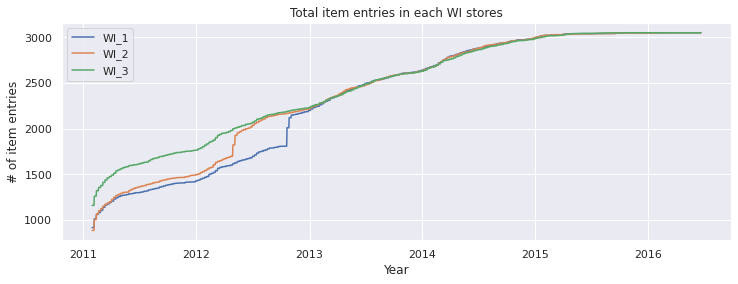

In [29]:
temp_series = df.groupby(["store_id", "date"])["item_id"].count()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_1"].values, label="WI_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_2"].values, label="WI_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_3"].values, label="WI_3")
plt.xlabel("Year")
plt.ylabel("# of item entries")
plt.title("Total item entries in each WI stores")
plt.legend()

우리가 이미 위에서 본 것처럼, 등록된 상품의 수의 추세는 각 상점에서와는 다르다.  
WI_2는 2012년 여름쯤에 상품 등록이 증가했고, WI_3는 그 해 11월 쯤에 증가했다.

2013년 부터, 모든 상점은 비슷한 추세를 가지고 있다. 다음은, TX 주에서의 상점이다!

<!--
As we've already seen above, the registered item count trends are different in each store.  
WI_2 increased its item register around summer in 2012, then WI_3 increased around November of that year.  

From 2013, all stores have similar trend.  Next, stores in TX states!
-->

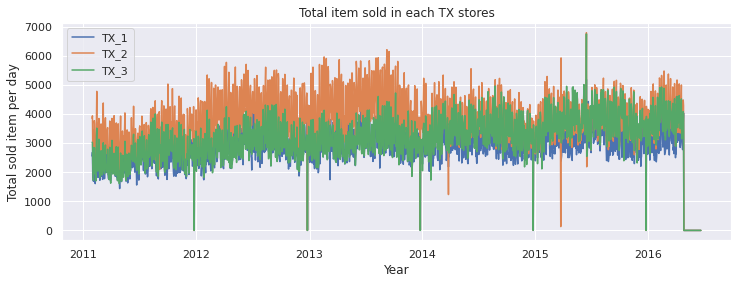

In [30]:
temp_series = df.groupby(["store_id", "date"])["value"].sum()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "TX_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "TX_1"].values, label="TX_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "TX_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "TX_2"].values, label="TX_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "TX_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "TX_3"].values, label="TX_3")
plt.xlabel("Year")
plt.ylabel("Total sold item per day")
plt.title("Total item sold in each TX stores")
plt.legend()

1. 이런, 2015년에 몇몇의 극심한 지점이 있는 것 같다.  
   예를 들어, 2월 쯤, TX2는 판매된 상품이 거의 0개이다. (나는 이 상점이 예외적으로 닫았을 것이라 가정한다.)  
   반대로, 그 해 한 여름날에, TX_3는 그것의 총 판매량이 매우 증가했다.  

2. TX_2는 2014년 전에 특히, 가장 많은 상품을 판매했다.

<!--
1. Oops, in 2015, it seems some extreme points exist.  
   For exmaple, around Febrary, TX_2 has almost 0 item sold. (I assume this store is closed exceptionally.)
   In contrast, in one summer day of that year, TX_3 increased its total item sold exprosively.
   
2. TX_2 has most item sold especially before 2014.
-->

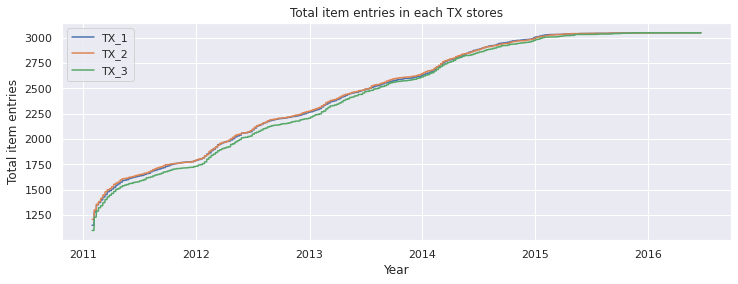

In [31]:
temp_series = df.groupby(["store_id", "date"])["item_id"].count()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "TX_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "TX_1"].values, label="TX_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "TX_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "TX_2"].values, label="TX_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "TX_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "TX_3"].values, label="TX_3")
plt.xlabel("Year")
plt.ylabel("Total item entries")
plt.title("Total item entries in each TX stores")
plt.legend()

다른 주와 비교해서, TX 상점은 등록된 항목과 비슷한 경향을 가지고 있다.

<!--
Compared to other states, TX stores have similar tendency regarding registered entries.
-->

In [32]:
temp_series = df.groupby(["store_id", "date"])["value"].sum()
temp_series

store_id  date      
CA_1      2011-01-29    4337
          2011-01-30    4155
          2011-01-31    2816
          2011-02-01    3051
          2011-02-02    2630
                        ... 
WI_3      2016-06-15       0
          2016-06-16       0
          2016-06-17       0
          2016-06-18       0
          2016-06-19       0
Name: value, Length: 19690, dtype: int32

In [33]:
# Find the day when items are sold less than 1000 of each store
# Let's take a look at TX_2 for example
temp_series.loc[(temp_series.values < 1000) & (temp_series.index.get_level_values("date") <= "2016-04-22")].loc["TX_2"]

date
2011-12-25      0
2012-12-25      0
2013-12-25     11
2014-12-25      7
2015-03-24    131
2015-12-25      0
Name: value, dtype: int32

1. 이런, 2015년에, 이것은 극변한 지점이 있는 것 같다.  
   예를 들어, 2월 쯤에, TX_2 는 거의 0개의 상품을 판매했다. (나는 이 상점이 예외적으로 닫았을 것이라 가정한다.)
   
   -> 2015-03-24 에, TX_2는 거의 상품을 판매하지 않았다.

<!--
1. Oops, in 2015, it seems some extreme points exist.  
   For exmaple, around Febrary, TX_2 has almost 0 item sold. (I assume this store is closed exceptionally.)
   
   -> On 2015-03-24, TX_2 has very little item sold. 
-->

In [34]:
# Find the day when items are sold most of each store
temp_series.groupby(["store_id"]).idxmax()

store_id
CA_1    (CA_1, 2013-08-25 00:00:00)
CA_2    (CA_2, 2016-04-03 00:00:00)
CA_3    (CA_3, 2013-09-08 00:00:00)
CA_4    (CA_4, 2016-01-31 00:00:00)
TX_1    (TX_1, 2015-06-15 00:00:00)
TX_2    (TX_2, 2015-06-15 00:00:00)
TX_3    (TX_3, 2015-06-15 00:00:00)
WI_1    (WI_1, 2015-01-31 00:00:00)
WI_2    (WI_2, 2016-04-09 00:00:00)
WI_3    (WI_3, 2012-06-02 00:00:00)
Name: value, dtype: object

In [35]:
temp_series = temp_series.reset_index()
temp_series

,store_id,date,value
0,CA_1,2011-01-29,4337
1,CA_1,2011-01-30,4155
2,CA_1,2011-01-31,2816
3,CA_1,2011-02-01,3051
4,CA_1,2011-02-02,2630
...,...,...,...
19685,WI_3,2016-06-15,0
19686,WI_3,2016-06-16,0
19687,WI_3,2016-06-17,0
19688,WI_3,2016-06-18,0


Text(0.5, 1.0, 'Item sold transition around its most sold day in CA_1 store')

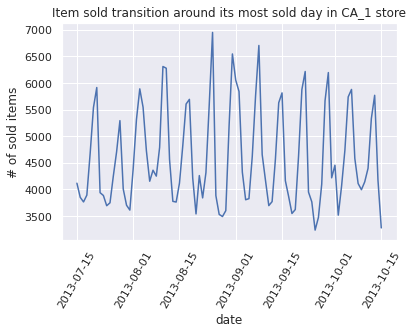

In [36]:
plt.plot(temp_series[(temp_series["store_id"] == "CA_1") & ((temp_series["date"] >= "2013-07-15") & (temp_series["date"] <= "2013-10-15"))]["date"],
         temp_series[(temp_series["store_id"] == "CA_1") & ((temp_series["date"] >= "2013-07-15") & (temp_series["date"] <= "2013-10-15"))]["value"])
plt.xticks(rotation=60)
plt.ylabel("# of sold items")
plt.xlabel("date")
plt.title("Item sold transition around its most sold day in CA_1 store")

# Item Sold relation Analysis
진행 중...  
(저는 Dynamic Factor Analysis 를 적용하고 이 튜토리얼의 코드를 실행하려고 노력했습니다. 그러나 유익한 결과를 얻을 수 없을 것 같습니다:
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html

더 상세하게 이 방법을 이해할 수 있는 누구든지, 댓글을 남겨주시면 감사하겠습니다.

<!--
Under Construction...  
(I tried to apply Dynamic Factor Analysis and execute the codes of this tutorial, but it seems I couldn't get informative outcome:
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html

To Whoever can understand this method more specifically, I appreciate your comments.
-->

## Apply Dynamic Factor Analysis Trial

In [37]:
# import statsmodels.api as sm

In [38]:
# item_id = "HOBBIES_1_008"
# temp_df = df.loc[df.item_id == item_id, ["date","store_id", "value"]]

In [39]:
# store_list = ["CA_1", "CA_2", "CA_3", "CA_4", "TX_1", "TX_2", "TX_3", "WI_1", "WI_2"]

# # temp_df.drop(columns="sell_price", inplace=True)
# temp_df_wide = pd.pivot_table(temp_df, index='date', columns='store_id', values="value")
# temp_df_wide.plot(figsize=(12, 4))
# plt.legend(bbox_to_anchor=(1.01, 1.01))

In [40]:
# diff_cols = ["diff_" + store for store in store_list]

# for store in store_list:
#     col = "diff_" + store
#     temp_df_wide.columns = temp_df_wide.columns.add_categories(col)
#     temp_df_wide[col] = np.log(temp_df_wide[store] + 0.1).diff() * 100
    
#     std_col = "std_" + col
    
#     temp_df_wide.columns = temp_df_wide.columns.add_categories(std_col)
#     temp_df_wide[std_col] = (temp_df_wide[col] - temp_df_wide[col].mean()) / temp_df_wide[col].std()


In [41]:
# std_cols = ["std_diff_" + store for store in store_list]

In [42]:
# endog = temp_df_wide.loc[:, std_cols]

# # Create the model
# mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=3, error_order=3)
# initial_res = mod.fit(method='powell', disp=False)
# res = mod.fit(initial_res.params, disp=False)

In [43]:
# print(res.summary(separate_params=False))

In [44]:
# from pandas_datareader.data import DataReader

# fig, ax = plt.subplots(figsize=(13,3))

# # Plot the factor
# dates = endog.index._mpl_repr()
# ax.plot(dates, res.factors.filtered[0], label='Factor')
# ax.legend()

# # Retrieve and also plot the NBER recession indicators
# rec = DataReader('USREC', 'fred', start=temp_df_wide.index.min(), end=temp_df_wide.index.max())
# ylim = ax.get_ylim()
# ax.fill_between(dates[:-3], ylim[0], ylim[1], rec.values[:-4,0], facecolor='k', alpha=0.1);

In [45]:
# This doesn't seem make sense.
# res.plot_coefficients_of_determination(figsize=(8,2));

# Store Analysis

In [46]:
temp_series = df.groupby(["store_id", "cat_id"])["value"].sum()

In [47]:
store_id_list_by_state = [["CA_1", "CA_2", "CA_3", "CA_4"], ["TX_1", "TX_2", "TX_3"], ["WI_1", "WI_2", "WI_3"]] 

Text(0.5, 0.98, 'Each category item sold in each store')

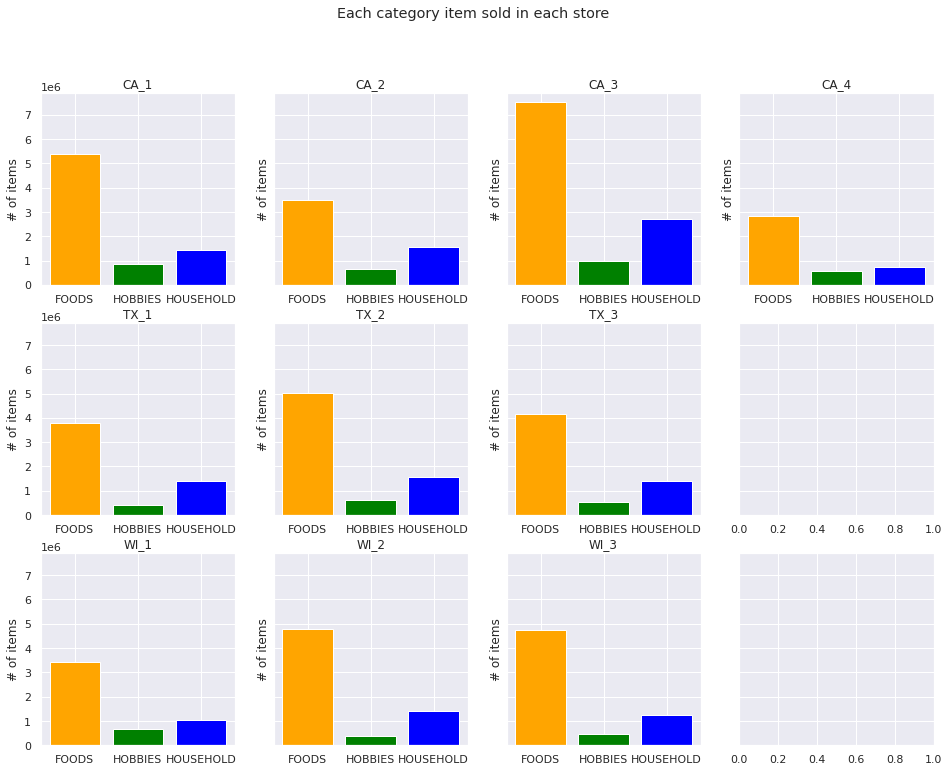

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharey=True) 

for row in range(len(store_id_list_by_state)):
    for col in range(len(store_id_list_by_state[row])):
        axs[row, col].bar(x=temp_series[temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col]].index.get_level_values("cat_id"),
                          height=temp_series[temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col]].values,
                         color=["orange", "green", "blue"], label=["FOODS", "HOBBIES", "HOUSEHOLD"])
        axs[row, col].set_title(store_id_list_by_state[row][col])
        axs[row, col].set_ylabel("# of items")

fig.suptitle("Each category item sold in each store")

Text(0.5, 0.98, 'Each category item sold percentage in each store')

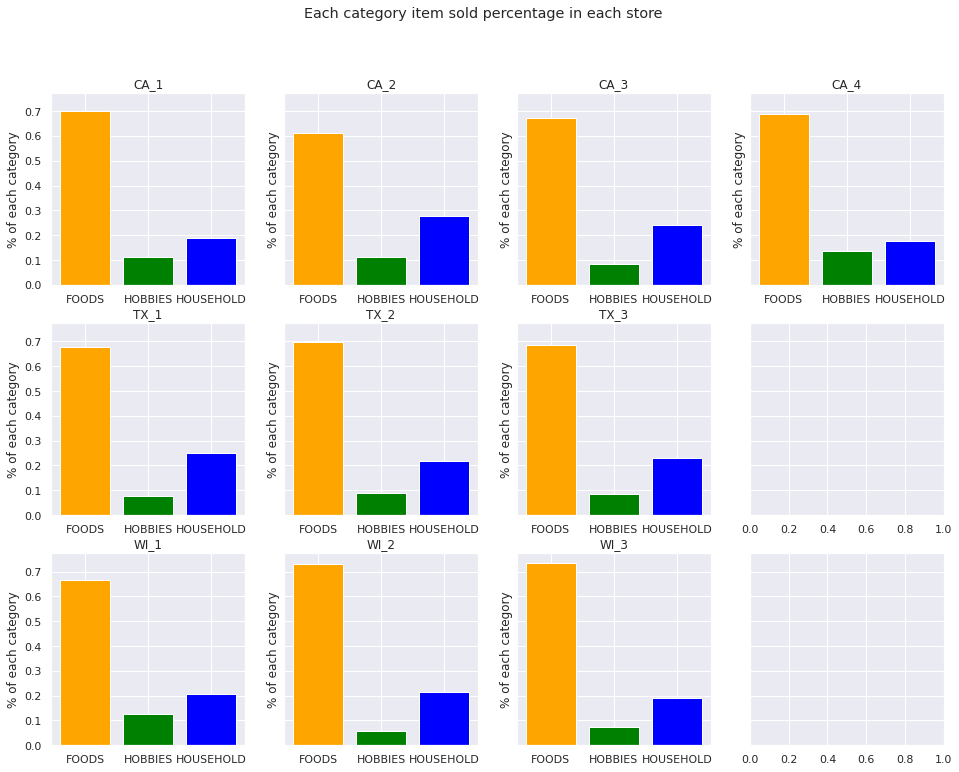

In [49]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharey=True) 

for row in range(len(store_id_list_by_state)):
    for col in range(len(store_id_list_by_state[row])):
        axs[row, col].bar(x=temp_series[temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col]].index.get_level_values("cat_id"),
                          height=temp_series[temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col]].values / temp_series[temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col]].sum(),
                         color=["orange", "green", "blue"], label=["FOODS", "HOBBIES", "HOUSEHOLD"])
        axs[row, col].set_title(store_id_list_by_state[row][col])
        axs[row, col].set_ylabel("% of each category")

fig.suptitle("Each category item sold percentage in each store")

In [50]:
cat_id = "FOODS"

temp_series = df.groupby(["store_id", "cat_id", "wday"])["value"].sum()
temp_series = temp_series[temp_series.index.get_level_values("cat_id") == cat_id]
temp_series

store_id  cat_id  wday
CA_1      FOODS   1       966112
                  2       990509
                  3       735141
                  4       647962
                  5       631624
                           ...  
WI_3      FOODS   3       634632
                  4       608954
                  5       590285
                  6       598550
                  7       684701
Name: value, Length: 70, dtype: int32

In [51]:
weekday = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]

Text(0.5, 0.98, 'HOBBIES item sold in each store in each day')

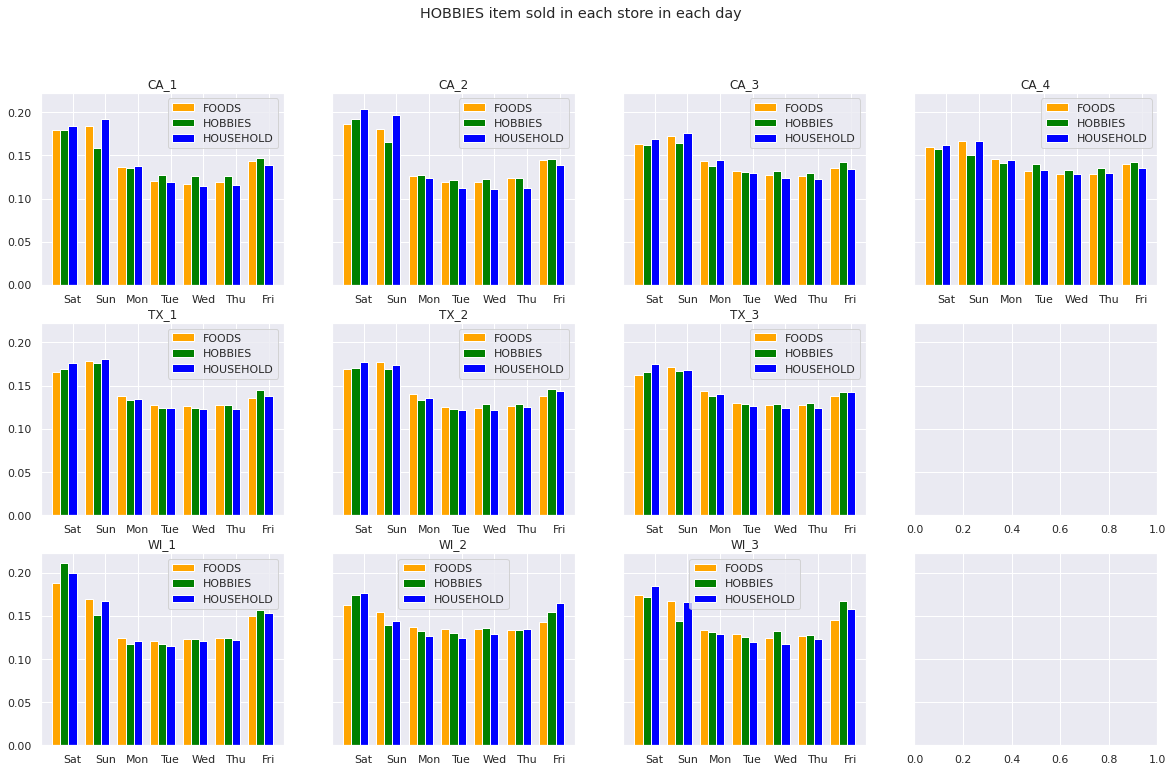

In [52]:
# Combine all these three figures.
cat_list = ["FOODS", "HOBBIES", "HOUSEHOLD"]
color_list = ["orange", "green", "blue"]
temp_series = df.groupby(["store_id", "cat_id", "wday"])["value"].sum()
width = 0.25

fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharey=True) 

for row in range(len(store_id_list_by_state)):
    for col in range(len(store_id_list_by_state[row])):
        for i, cat in enumerate(cat_list):
            height_numerator = temp_series[(temp_series.index.get_level_values("cat_id") == cat) & (temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col])].values
            height_denominater = height_numerator.sum()

            axs[row, col].bar(x=temp_series[(temp_series.index.get_level_values("cat_id") == cat) & (temp_series.index.get_level_values("store_id") == store_id_list_by_state[row][col])].index.get_level_values("wday") + width * (i-1),
                              height=height_numerator / height_denominater,
                             tick_label=weekday, color=color_list[i], width=width, label=cat)
            axs[row, col].set_title(store_id_list_by_state[row][col])
            axs[row, col].legend()
            
fig.suptitle("HOBBIES item sold in each store in each day")

# Snap Purchase Analysis
snap 구매가 허용된 날은 어떻게 분포되었는 지 확인하자.

<!--
Let's see how snap purchase allowed day is distributed.
-->

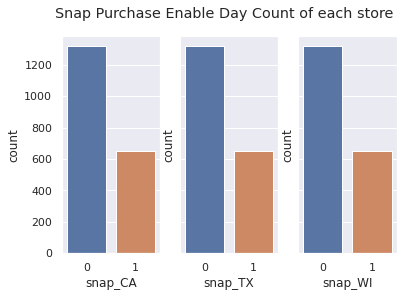

In [53]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle("Snap Purchase Enable Day Count of each store")

sns.countplot(x="snap_CA", data =calendar_df, ax=axs[0])
sns.countplot(x="snap_TX", data =calendar_df, ax=axs[1])
sns.countplot(x="snap_WI", data =calendar_df, ax=axs[2])

1. 좋다, snap 구매가 허용된 날의 총 수는 3개의 상점에서 유사한 것으로 보인다.

2. snap 구매가 허용된 날의 총 수는 가능하지 않은 날의 약 절반정도이다.

다음으로 snap 구매가 일년 동안 얼마나 분포되었는 지 확인해보자.

<!--
1. OK, the total count of snap purchase enable day looks similar in these three stores.

2. The total count of snap purchase enable day is about one half of that of non-enable day.

Next Let's see whether snap purchase is how-distributed in one year.
-->

In [54]:
temp_df = calendar_df.groupby(["year"])[["snap_CA", "snap_TX", "snap_WI"]].sum()
temp_df

,snap_CA,snap_TX,snap_WI
year,,,
2011,110,110,110
2012,120,120,120
2013,120,120,120
2014,120,120,120
2015,120,120,120
2016,60,60,60


1. 좋다. 각 주별로 총 snap 구매가 허용된 날의 총 수는 모든 해에서 동일하다.

2. 2011년부터 2015년까지, snap 구매가 허용된 날은 약 120일이다.  
   (2016년에 이르러서야, 1년의 절반이었다.)

<!--
1. OK. Total snap purchase allowed day of each state is the same in all years.

2. From 2011 to 2015, there are about 120 days when snap purchase is allowed.  
   (As for 2016, we only have the first half of whole year.)
-->

Text(0.5, 1.0, 'Snap Purchase allowed day yearly transition')

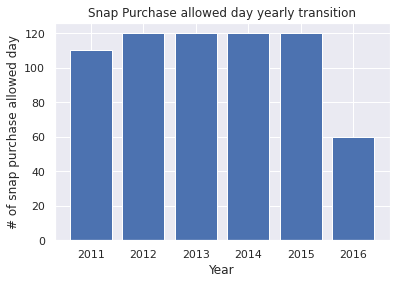

In [55]:
# This cell is just visuallizing the above dataframe.
plt.bar(temp_df.index, temp_df.snap_CA)
plt.ylabel("# of snap purchase allowed day")
plt.xlabel("Year")
plt.title("Snap Purchase allowed day yearly transition")

좋다, 한 해에 총 수가 모든 해와 모든 주에서 거의 같다.  
월간 분포는 어떨까?

<!--
OK, total count in one year is almost the same in all years and all states.
How about monthly distribution?
-->

In [56]:
temp_df = calendar_df[calendar_df["year"] == 2015].groupby(["month"])[["snap_CA", "snap_TX", "snap_WI"]].sum()
temp_df

,snap_CA,snap_TX,snap_WI
month,,,
1,10,10,10
2,10,10,10
3,10,10,10
4,10,10,10
5,10,10,10
6,10,10,10
7,10,10,10
8,10,10,10
9,10,10,10


그 해 동안, 한 달동안, 10일의 snap 구매가 허용된 날들이 있었다.  
이 경향은 2012년부터 2015년까지 같다.  
(2011년에 1월에는 snap 날이 없다.)

<!--
Through the year, we have 10 snap purchase allowed days in one month.  
This tendency is the same from 2012 to 2015.  
(In 2011, no snap days in January)
-->

Text(0.5, 1.0, 'Snap Purchase allowed day monthly trend')

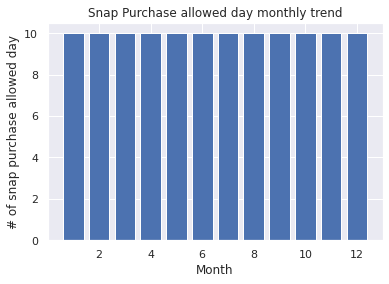

In [57]:
# Just visualizing the above dataframe
plt.bar(temp_df.index, temp_df.snap_CA)
plt.ylabel("# of snap purchase allowed day")
plt.xlabel("Month")
plt.title("Snap Purchase allowed day monthly trend")

좋다, 한달에 총 수는 전체 해로 보면 같다.  
주간 분포는 어떨까?

<!--
OK, total count in one month is the same through the whole year.
How about weekly distribution?
-->

In [58]:
temp_df = calendar_df[calendar_df["year"] == 2015].groupby(["weekday"])[["snap_CA", "snap_TX", "snap_WI"]].sum()
temp_df

,snap_CA,snap_TX,snap_WI
weekday,,,
Friday,17,17,16
Monday,17,17,18
Saturday,16,16,16
Sunday,17,19,18
Thursday,18,18,19
Tuesday,18,17,16
Wednesday,17,16,17


주간 경향에 얘기한 것처럼, 우리는 편향된 분포를 찾을 수 없다.  
연간 총합과 월간 총합처럼 거의 동일하게 분포되어 있다.


<!--
Regarding weekly trend, we can find no biased distribution.  
This is also almost uniformly distributed like year total and month total.
-->

Text(0.5, 1.0, 'Snap Purchase allowed day weekly trend')

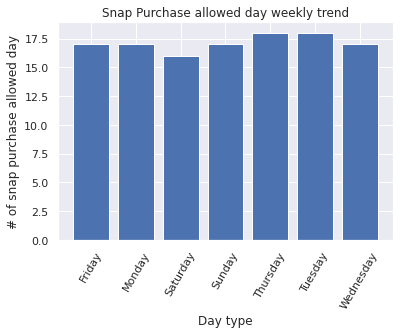

In [59]:
plt.bar(temp_df.index, temp_df.snap_CA)
plt.xticks(rotation=60)
plt.ylabel("# of snap purchase allowed day")
plt.xlabel("Day type")
plt.title("Snap Purchase allowed day weekly trend")

위에 것들에서, 우리는 "snap이 가능한 날은 3일에 한번 처럼 동일하게 분포되었구나." 라고 생각할 지도 모른다. 왜냐하면 모든 barplot이 어떤 달이나 어떤 날이나 그렇게 다르지 않다는 것을 보여주기 때문이다.  
그러나, 이것은 **완전히 다르다** 라는 것을 밑에서 보여줄 것이다.
(예, snap 구매 가능한 날은 편향되게 분포되어 있다.)

<!--
From above things, we may think "oh, snap_enable day is distributed uniformly, like 1 day in 3 consecutive days." because all of these barplot show it's not so different in any month, any day.  
However, it is **completely different** as I'll show you below.  
(i.e. snap purchase enable day is distributed biasedly.)
-->

In [60]:
# Make temp dataframe with necessary information
temp_df = df.groupby(["date", "state_id"])[["value"]].sum()
temp_df = temp_df.reset_index()
temp_df = temp_df.merge(calendar_df[["date", "snap_CA", "snap_TX", "snap_WI"]], on="date")
temp_df

,date,state_id,value,snap_CA,snap_TX,snap_WI
0,2011-01-29,CA,14195,0,0,0
1,2011-01-29,TX,9438,0,0,0
2,2011-01-29,WI,8998,0,0,0
3,2011-01-30,CA,13805,0,0,0
4,2011-01-30,TX,9630,0,0,0
...,...,...,...,...,...,...
5902,2016-06-18,TX,0,0,0,0
5903,2016-06-18,WI,0,0,0,0
5904,2016-06-19,CA,0,0,0,0
5905,2016-06-19,TX,0,0,0,0


예를 들어 가장 많이 판매된 상품을 찾고, snap 구매가 허용된 flag와 values를 사이의 관계를 보자.

<!--
Find the most item sold day for example and take a look at the relationship between snap purchase allowed flag and values.
-->

In [61]:
np.argmax(temp_df.groupby(["date", "state_id"])["value"].sum())

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


(Timestamp('2016-03-06 00:00:00'), 'CA')

In [62]:
temp_df = temp_df[(temp_df.date >= "2016-02-15") & (temp_df.date <= "2016-03-25") & (temp_df.state_id == "CA")]
temp_df

,date,state_id,value,snap_CA,snap_TX,snap_WI
5529,2016-02-15,CA,19231,0,1,1
5532,2016-02-16,CA,15249,0,0,0
5535,2016-02-17,CA,14555,0,0,0
5538,2016-02-18,CA,15306,0,0,0
5541,2016-02-19,CA,17114,0,0,0
5544,2016-02-20,CA,21348,0,0,0
5547,2016-02-21,CA,22538,0,0,0
5550,2016-02-22,CA,16269,0,0,0
5553,2016-02-23,CA,14616,0,0,0
5556,2016-02-24,CA,13943,0,0,0


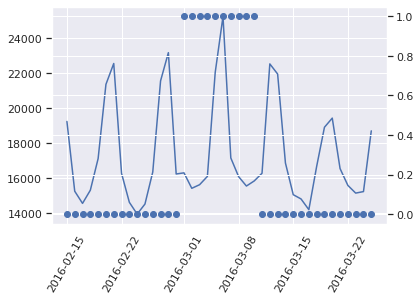

In [63]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=60)
ax1.plot("date", "value", data=temp_df[temp_df.state_id == "CA"])
ax2 = ax1.twinx()  
ax2.scatter("date", "snap_CA", data=temp_df[temp_df.state_id == "CA"])

위 그림에서, 각 plot은 CA에서 snap 구매가 허용된 날인 지 아닌 지를 의미한다.  
여러분들이 보는 것처럼, snap 구매는 3일 후에 하루처럼 규칙적으로 분포되어 있지 않다.  
(ex. 2016-03-31 > 2016-03-04 > 2016-03-07 > ...)  
이것은 위 그럼처럼 사실 편향되게 분포되어 있다.  
(예, Snap 구매가 가능한 날은 2016-03-01 부터 2016-03-19까지 계속된다.)  
그리고 이런 날에, 판매는 또한 증가했다.

<!--
In above figure, each plot means whether the day allows snap purchase or not in CA.  
As you can see, snap purchase enable day is not regularly distributed like one day in three consective days.  
(ex. 2016-03-01 > 2016-03-04 > 2016-03-07 > ...)  
It is actually biasedly distributed like the figure above.  
(i.e. Snap purchase Enable Day continues from 2016-03-01 to 2016-03-10)  
And on these days, sales are also increased.  
-->

# Event Pattern Analysis
event_name_1 컬럼에서 행사 패턴을 확인하자.  
(event_name_2 컬럼의 경우, event_name_1 컬럼과 비교하면 null이 아닌 값들이 훨씬 적다.)

<!--
Let's check event pattern in event_name_1 column.  
(As for event_name_2 column, there are much less non-null values compeared to event_name_1 column.
-->

Text(0.5, 1.0, 'Event Type Count in event name 1 column')

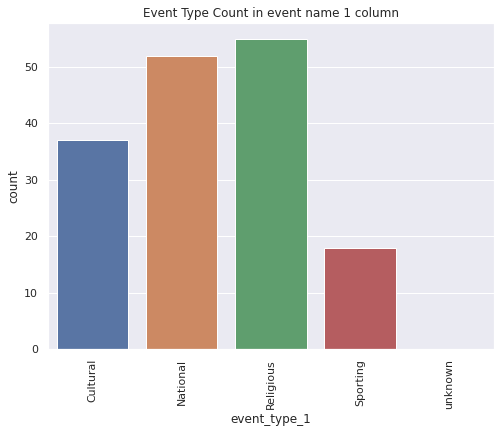

In [64]:
plt.figure(figsize=(8, 6))
sns.countplot(x="event_type_1", data=calendar_df[calendar_df["event_name_1"] != "unknown"])
plt.xticks(rotation=90)
plt.title("Event Type Count in event name 1 column")

좋다, 행사 타입 분포는 위 그래프와 같다.  
(대부분의 값들이 사실 "unknown" 이나 시각화를 위해 불명값은 제외했다.)

<!--
OK, event tyoe distributes like the graph above.   
(Most of the values are actually "unknown", but for visualization, I omitted unknown value)
-->

Text(0.5, 1.0, 'Snap Purchse allowed day Count in each event category')

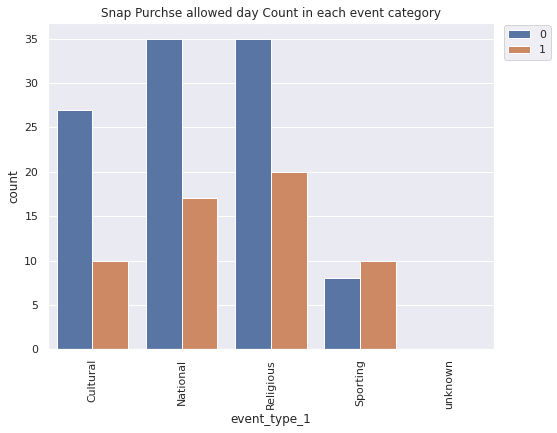

In [65]:
# Let's check the distribution of snap purchase day and event day
# Accirding to the graph, Snap CA is allowed especially when sport event occurs.

plt.figure(figsize=(8, 6))
sns.countplot(x="event_type_1", data=calendar_df[calendar_df["event_name_1"] != "unknown"], hue="snap_CA")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.title("Snap Purchse allowed day Count in each event category")

이벤트 날의 판매를 확인하자!

<!--
Let's check the sales of event day!
-->

In [66]:
temp_series = df.groupby(["cat_id", "event_type_1"])["value"].mean()
temp_series

cat_id     event_type_1
FOODS      Cultural        2.000074
           National        1.777578
           Religious       1.953661
           Sporting        1.999117
           unknown         2.041676
HOBBIES    Cultural        0.656127
           National        0.525645
           Religious       0.659141
           Sporting        0.612730
           unknown         0.690233
HOUSEHOLD  Cultural        0.822631
           National        0.737024
           Religious       0.828819
           Sporting        0.780683
           unknown         0.880896
Name: value, dtype: float64

Text(0.5, 0, 'Event Type')

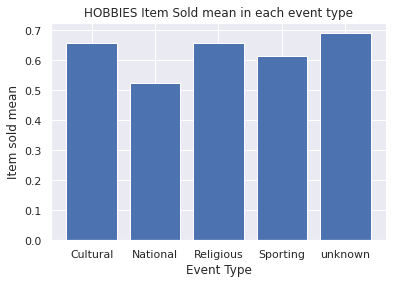

In [67]:
plt.bar(x=temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("event_type_1"), 
        height=temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values)
plt.title("HOBBIES Item Sold mean in each event type")
plt.ylabel("Item sold mean")
plt.xlabel("Event Type")

나는 몇몇의 문화적이거나 스포츠 행사가 일어났을 때, HOBBIES 상품이 더 잘 팔리는 경향이 있지 않을까 생각했다.  
그러나, 이 plot은 이런 가설이 분명하다고 의미하지 않는다.

<!--
I thought when some cultual or sporting event occurs, HOBBIES item are more likely to be sold.  
However, this plot doesn't mean this hypothesis clearly.
-->

## One Item Features Analysis

In [68]:
# find out most sold item for example
df[df["value"] == df["value"].max()]

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_WI,store_id,item_id,sell_price,cat_id,dept_id,state_id,week,day,quarter
18457320,2013-09-14,FOODS_3_090_CA_3_validation,763,11334,Saturday,1,9,2013,unknown,unknown,...,1,CA_3,FOODS_3_090,1.0,FOODS,3,CA,37,14,3


이 데이터셋에서 대부분의 매진 상품은 FOODS_3_090_CA_3_validation 이다.

<!--
The most sold out item in this dataseet is FOODS_3_090_CA_3_validation
-->

In [69]:
target_id = "FOODS_3_090_CA_3_validation"
temp_df = df[df["id"] == target_id]
temp_df

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_WI,store_id,item_id,sell_price,cat_id,dept_id,state_id,week,day,quarter
22078,2011-01-29,FOODS_3_090_CA_3_validation,108,11101,Saturday,1,1,2011,unknown,unknown,...,0,CA_3,FOODS_3_090,1.250000,FOODS,3,CA,4,29,1
22079,2011-01-30,FOODS_3_090_CA_3_validation,132,11101,Sunday,2,1,2011,unknown,unknown,...,0,CA_3,FOODS_3_090,1.250000,FOODS,3,CA,4,30,1
22080,2011-01-31,FOODS_3_090_CA_3_validation,102,11101,Monday,3,1,2011,unknown,unknown,...,0,CA_3,FOODS_3_090,1.250000,FOODS,3,CA,5,31,1
22081,2011-02-01,FOODS_3_090_CA_3_validation,120,11101,Tuesday,4,2,2011,unknown,unknown,...,0,CA_3,FOODS_3_090,1.250000,FOODS,3,CA,5,1,1
22082,2011-02-02,FOODS_3_090_CA_3_validation,106,11101,Wednesday,5,2,2011,unknown,unknown,...,1,CA_3,FOODS_3_090,1.250000,FOODS,3,CA,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47519875,2016-06-15,FOODS_3_090_CA_3_validation,0,11620,Wednesday,5,6,2016,unknown,unknown,...,1,CA_3,FOODS_3_090,1.599609,FOODS,3,CA,24,15,2
47519876,2016-06-16,FOODS_3_090_CA_3_validation,0,11620,Thursday,6,6,2016,unknown,unknown,...,0,CA_3,FOODS_3_090,1.599609,FOODS,3,CA,24,16,2
47519877,2016-06-17,FOODS_3_090_CA_3_validation,0,11620,Friday,7,6,2016,unknown,unknown,...,0,CA_3,FOODS_3_090,1.599609,FOODS,3,CA,24,17,2
47691241,2016-06-18,FOODS_3_090_CA_3_validation,0,11621,Saturday,1,6,2016,unknown,unknown,...,0,CA_3,FOODS_3_090,1.599609,FOODS,3,CA,24,18,2


In [70]:
weekday = ["Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"]

# Create one hot weekday column from wday column to calculate correlation later. 
for idx, val in enumerate(weekday):
    temp_df.loc[:, val] = (temp_df["wday"] == idx + 1).astype("int8")

temp_df
# sns.heatmap(temp_df[["value", "snap_CA", ]].corr(), annot=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,week,day,quarter,Sat,Sun,Mon,Tue,Wed,Thu,Fri
22078,2011-01-29,FOODS_3_090_CA_3_validation,108,11101,Saturday,1,1,2011,unknown,unknown,...,4,29,1,1,0,0,0,0,0,0
22079,2011-01-30,FOODS_3_090_CA_3_validation,132,11101,Sunday,2,1,2011,unknown,unknown,...,4,30,1,0,1,0,0,0,0,0
22080,2011-01-31,FOODS_3_090_CA_3_validation,102,11101,Monday,3,1,2011,unknown,unknown,...,5,31,1,0,0,1,0,0,0,0
22081,2011-02-01,FOODS_3_090_CA_3_validation,120,11101,Tuesday,4,2,2011,unknown,unknown,...,5,1,1,0,0,0,1,0,0,0
22082,2011-02-02,FOODS_3_090_CA_3_validation,106,11101,Wednesday,5,2,2011,unknown,unknown,...,5,2,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47519875,2016-06-15,FOODS_3_090_CA_3_validation,0,11620,Wednesday,5,6,2016,unknown,unknown,...,24,15,2,0,0,0,0,1,0,0
47519876,2016-06-16,FOODS_3_090_CA_3_validation,0,11620,Thursday,6,6,2016,unknown,unknown,...,24,16,2,0,0,0,0,0,1,0
47519877,2016-06-17,FOODS_3_090_CA_3_validation,0,11620,Friday,7,6,2016,unknown,unknown,...,24,17,2,0,0,0,0,0,0,1
47691241,2016-06-18,FOODS_3_090_CA_3_validation,0,11621,Saturday,1,6,2016,unknown,unknown,...,24,18,2,1,0,0,0,0,0,0


In [71]:
# Create Event Flag (Any events occur: 1, otherwise: 0)
# Create Each Event Type Flag
temp_df.loc[:, "is_event_day"] = (temp_df["event_name_1"] != "unknown").astype("int8")
temp_df.loc[:, "is_sport_event"] = (temp_df["event_type_1"] == "Sporting").astype("int8")
temp_df.loc[:, "is_cultural_event"] = (temp_df["event_type_1"] == "Cultural").astype("int8")
temp_df.loc[:, "is_national_event"] = (temp_df["event_type_1"] == "National").astype("int8")
temp_df.loc[:, "is_religious_event"] = (temp_df["event_type_1"] == "Religious").astype("int8")

temp_df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,Mon,Tue,Wed,Thu,Fri,is_event_day,is_sport_event,is_cultural_event,is_national_event,is_religious_event
22078,2011-01-29,FOODS_3_090_CA_3_validation,108,11101,Saturday,1,1,2011,unknown,unknown,...,0,0,0,0,0,0,0,0,0,0
22079,2011-01-30,FOODS_3_090_CA_3_validation,132,11101,Sunday,2,1,2011,unknown,unknown,...,0,0,0,0,0,0,0,0,0,0
22080,2011-01-31,FOODS_3_090_CA_3_validation,102,11101,Monday,3,1,2011,unknown,unknown,...,1,0,0,0,0,0,0,0,0,0
22081,2011-02-01,FOODS_3_090_CA_3_validation,120,11101,Tuesday,4,2,2011,unknown,unknown,...,0,1,0,0,0,0,0,0,0,0
22082,2011-02-02,FOODS_3_090_CA_3_validation,106,11101,Wednesday,5,2,2011,unknown,unknown,...,0,0,1,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Heatmap with values, snap_CA,  event_flag and weekday columns')

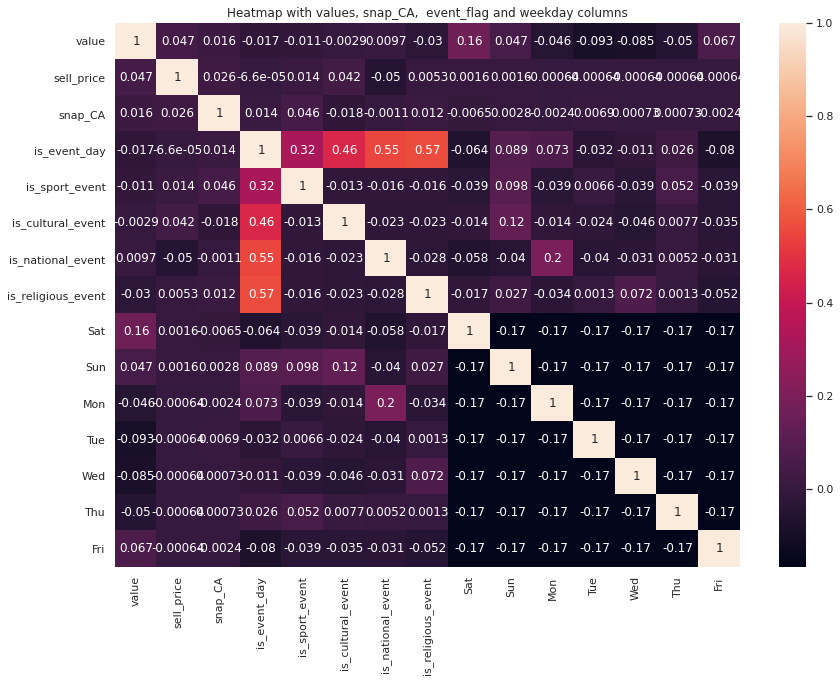

In [72]:
# Plot Heatmap with these columns made in previous cells
plt.figure(figsize=(14, 10))
sns.heatmap(temp_df[["value", "sell_price", "snap_CA", "is_event_day", "is_sport_event", "is_cultural_event", "is_national_event", "is_religious_event"] + weekday].corr(), annot=True)
plt.title("Heatmap with values, snap_CA,  event_flag and weekday columns")

우리는 다음의 것들을 알 수 있다.
1. value와 다른 열들의 상관관계에 관해:
   - snap 구매와 다른 행사 flag는 거의 상관관계가 없다.
   - 토요일은 value에 가장 많은 긍정적 영향을 갖고 있고, 화요일은 가장 부정적인 영향을 갖고 있다.
     (우리는 이전에 토요일이 한 주에 가장 많은 상품을 판매한 날이라고 보았다. [here](#Item-Sold-in-each-day-type).)  
     
     
2. snap_CA와 평일 커럼의 상관관계에 관해:
   - 우리가 이전에 본 것처럼, snap_CA는 각 날의 타입에 동일하게 분포되어 있다.
     따라서, snap_CA와 평일(월,화,수 ..) 컬럼 사이에 상관관계는 거의 0이다.  


3. 나머지:
   - 행사와 일요일의 상관관계를 보면, 거의 0.089이다.
     저는 대부분의 행사 일요일에 했다고 생각했다. 그러나 이것은 제가 예상한 것처럼 많지 않았다.
   - 판매 가격에 관해서는 아래를 보자.

<!--
We can find the following things.
1. Regarding value and other columns correlation:
   - snap purchase and other events flag has little correltion.
   - Saturday has the most positive effect on values, and Tuesday has the most negative effect.  
     (We've previously seen Saturday is the most item sold day in one week [here](#Item-Sold-in-each-day-type).)
     
2. Regarding snap_CA and weekdays columns correlation:
   - As we've previously seen, snap_CA is uniformly distributed in each day type.  
     Thus, the correlation between snap_CA and weekdays columns (ex. Monday, Tuesday, ...) are almost 0.

3. Others:
   - Looking at event and sunday correlation,it is just 0.089.  
     I thought most part of events oocur on Sunday, but it wasn't so much as I had exoected.
   - Regarding sell price, we look below.
-->

## Sell Price Analysis

In [73]:
df.groupby("cat_id")["sell_price"].mean()

cat_id
FOODS        3.250000
HOBBIES      5.332031
HOUSEHOLD    5.464844
Name: sell_price, dtype: float16

In [74]:
df.groupby("cat_id")["sell_price"].describe()

,count,mean,std,min,25%,50%,75%,max
cat_id,,,,,,,,
FOODS,22200673.0,NaN,0.0,0.010002,1.980469,2.679688,3.980469,19.484375
HOBBIES,8959085.0,NaN,0.0,0.010002,1.969727,3.970703,7.468750,30.984375
HOUSEHOLD,16575639.0,NaN,0.0,0.010002,2.980469,4.941406,6.968750,107.312500


*.decribe* 함수를 사용했을 때, mean = NaN인 이유를 이해하지 못 했다. 그러나 *.mean()* 함수는 카테고리의 판매 가격 평균을 정확히 계산한다.  
여러 방식으로 그려보자.

<!--
I don't understand why mean = NaN when using *.describe* method, however, *.mean()* method accurately calculate category's sell price mean.  
Let's plot it with some ways!
-->

Text(0.5, 1.0, 'Boxplot of sell prices in each category')

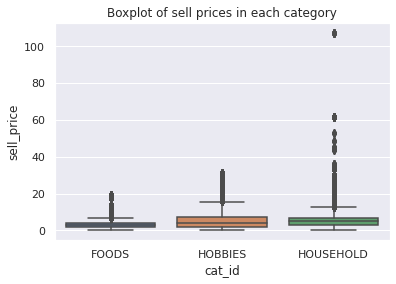

In [75]:
sns.boxplot(data=df, x="cat_id", y='sell_price')
plt.title("Boxplot of sell prices in each category")

일부 HOUSEHOLD 카테고리의 가격은 100 \$ 보다 훨씬 비싸다.  
반면에, FOODS은 거의 약5에서 10 \$ 이고, 큰 편차가 없다.

<!--
The price of some Household category is super expensive like over 100 \$.  
On the other hand, foods are mostly around 5 to 10 \$ and don't have a large deviation.
-->

Text(0.5, 1.0, 'Boxplot of sell prices in each store')

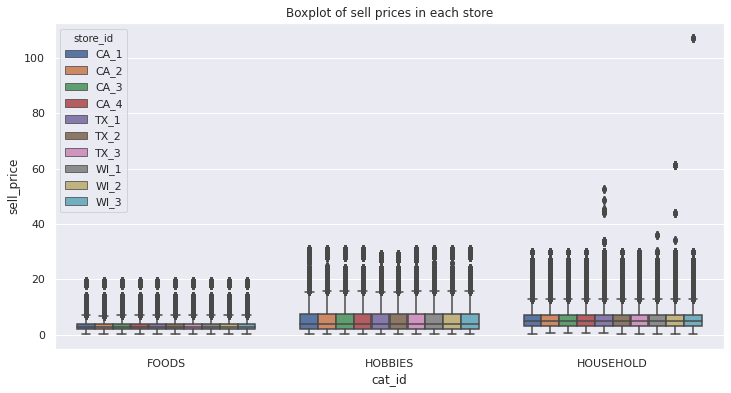

In [76]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="cat_id", y='sell_price', hue="store_id")
plt.title("Boxplot of sell prices in each store")

이미 HOUSEHOLD 중 일부가 예외적으로 판매 가격이 비싸다는 것을 봤다.
이제 이 상품들을 몇몇의 상점을 제외하면 더 이상 어디서도 판매하지 않는 다는 것을 알았다.

<!--
We've already seen HOUSEHOLD has some exceptionally expensive sell price.  
Now we found these items aren't sold anywhere, but only in some stores.
-->

Text(0.5, 1.0, "Sell price change of 'FOODS_3_090' in each store")

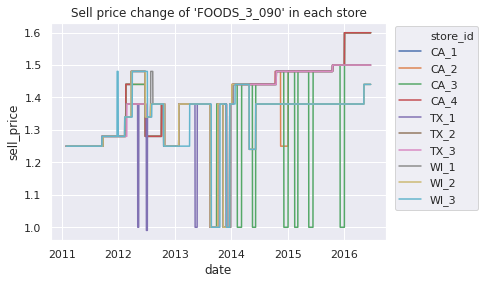

In [77]:
# One Item Sell Price Transition
sns.lineplot(data=df[df["item_id"] == "FOODS_3_090"], x='date', y='sell_price', hue="store_id")
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.title("Sell price change of 'FOODS_3_090' in each store")

상품이 같다고 하면, 판매 가격은 각 상점과 각 계절에 따라 약간 다르다. -> 프로모션 시즌?

<!--
Though the item is same, sell price is slightly different in each store and each season. -> Some promotion season?
-->

In [78]:
df["is_event_day"] = (df["event_name_1"] != "unknown").astype("int8")
df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,store_id,item_id,sell_price,cat_id,dept_id,state_id,week,day,quarter,is_event_day
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,unknown,unknown,...,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,4,29,1,0
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,unknown,unknown,...,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,4,30,1,0
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,unknown,unknown,...,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,31,1,0
3,2011-02-01,HOBBIES_1_008_CA_1_validation,0,11101,Tuesday,4,2,2011,unknown,unknown,...,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,1,1,0
4,2011-02-02,HOBBIES_1_008_CA_1_validation,0,11101,Wednesday,5,2,2011,unknown,unknown,...,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,2,1,0


Text(0.5, 1.0, 'Heatmap of value, sell_price and event flag')

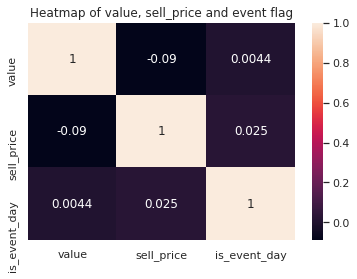

In [79]:
sns.heatmap(df[df["item_id"] == "FOODS_3_090"][["value", "sell_price", "is_event_day"]].corr(), annot=True)
plt.title("Heatmap of value, sell_price and event flag")

행사 날 flag와 판매 가격은 그렇게 강한 관계가 없다.
그러나, 우리가 몇몇 행사를 위해 상품을 샀을 때, 우리는 아마도 행사 1주에서 1일 전에 산다. 당일이 아니라.
그래서 우리는 이것을 고려해야한다. (나는 이것을 나중에 분석할 것이다.)

<!--
Event Day flag and Sell Price don't have so strong relationship.  
However, when we buy items for some events, we perhaps buy items 1 week ~ 1 day before the event, not on the same day.  
So we have to take this into consideration.  (I'll tackle with this analysis later.)
-->

In [80]:
temp_df = df.groupby(["date", "cat_id"])["sell_price"].mean()
temp_df

date        cat_id   
2011-01-29  FOODS        2.957031
            HOBBIES      4.671875
            HOUSEHOLD    5.433594
2011-01-30  FOODS        2.957031
            HOBBIES      4.671875
                           ...   
2016-06-18  HOBBIES      5.535156
            HOUSEHOLD    5.472656
2016-06-19  FOODS        3.347656
            HOBBIES      5.535156
            HOUSEHOLD    5.472656
Name: sell_price, Length: 5907, dtype: float16

Text(0.5, 1.0, 'Mean price transition of each category')

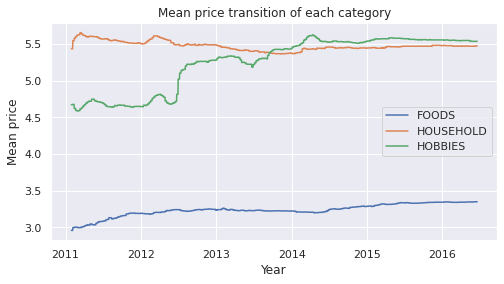

In [81]:
plt.figure(figsize=(8,4))
sns.lineplot(x=temp_df[temp_df.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), y=temp_df[temp_df.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
sns.lineplot(x=temp_df[temp_df.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), y=temp_df[temp_df.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
sns.lineplot(x=temp_df[temp_df.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), y=temp_df[temp_df.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Mean price")
plt.title("Mean price transition of each category")

각 카테고리의 상품 가격의 평균은 이 데이터셋의 주기에서 몇몇의 변화가 있는 것 같다.
이것은 단순히 이후 주기에 비싼 상품이 증가했기 때문일까?

<!--
The mean of item price in each category seems to have some change in these dataset periods.  
Is this simply because the expensive item increased in later periods?
-->

In [82]:
temp_df = df.groupby(["date", "cat_id"])["item_id"].count()

Text(0.5, 1.0, 'Registered Item Counts Transition in each category')

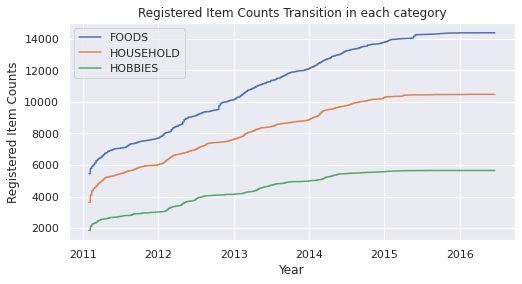

In [83]:
plt.figure(figsize=(8,4))
sns.lineplot(x=temp_df[temp_df.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), y=temp_df[temp_df.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
sns.lineplot(x=temp_df[temp_df.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), y=temp_df[temp_df.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
sns.lineplot(x=temp_df[temp_df.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), y=temp_df[temp_df.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Registered Item Counts")
plt.title("Registered Item Counts Transition in each category")

이런 값의 양이 다른다는 것을 통해서 모든 카테고리는 비슷한 추세를 갖고 있다.
2015부터, 등록된 상품의 수는 상대적으로 상수처럼 보인다.

<!--
All categories have similar trends though the volume of these values are different.  
From 2015, the number of registered items is seemed to be relatively constant.
-->

## Sell price and value relationship

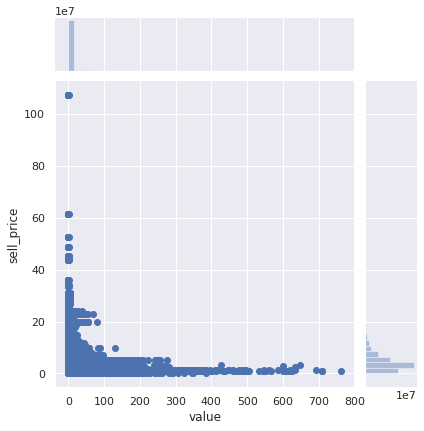

In [84]:
sns.jointplot(df["value"], df["sell_price"])

이 결과 또한 흥미롭다.
물론, 상품의 가격이 비쌀 때, 상품이 덜 판매된다. (왼쪽위 영역)
그리고 가격이 낮아질 때, 더 많은 상품이 팔린다. (오른쪽아래 영역)
그러나, 관계는 선형적이지 않은 것 같으나 역 비례처럼 보인다.

<!--
This result is also interesting.  
Of course, when the price of item is expensive, less items are sold. (left top field)  
And when the price gets lower, more items are sold.  (Right bottom field)  
However, the relationship is not likely linear but likely to be inverse propotion.
-->

## Discount Season Presumption
모든 상품이 Walmart의 평소보다 더 낮은 가격인 기간이 있을까?

<!--
Is there a period when all items have lower price than usual in Walmart?
-->

In [85]:
df["sell_price_diff"] = df.groupby("id")["sell_price"].transform(lambda x: x - x.mean()).astype("float32")

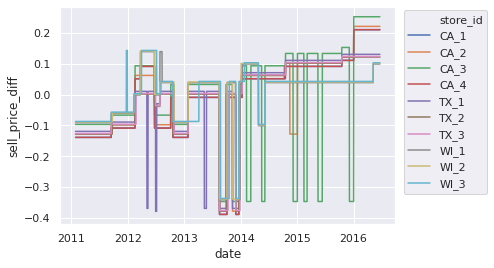

In [86]:
sns.lineplot(df[df["item_id"] == "FOODS_3_090"]["date"],df[df["item_id"] == "FOODS_3_090"]["sell_price_diff"], hue=df["store_id"]) 
plt.legend(bbox_to_anchor=(1.01, 1.01))

모든 상점이 2013년 하반기에 평균 가격보다 더 낮은 가격이었다.

<!--
All store has lower price than mean value in the latter half of 2013.  
-->

In [87]:
temp_df = df[df["item_id"] == "FOODS_3_090"].groupby("date")["value"].sum()

Text(0.5, 1.0, 'FOODS_3_090 sold number and price difference from mean')

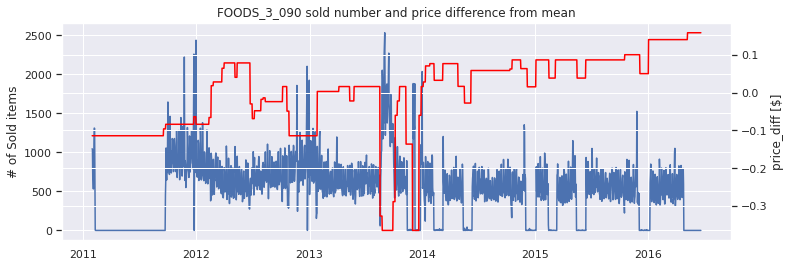

In [88]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(temp_df)
ax1.set_ylabel("# of Sold items")
ax2 = ax1.twinx()  
ax2.plot(df[(df["item_id"] == "FOODS_3_090") & (df["store_id"] == "CA_3")]["date"],
         df[df["item_id"] == "FOODS_3_090"].groupby("date")["sell_price_diff"].mean(), color="red")
ax2.set_ylabel("price_diff [\$]") 
plt.title("FOODS_3_090 sold number and price difference from mean")

FOODS_3_090의 경우, 가격이 평균보다 낮아졌을 때, 판매 수는 더 높았다.  
특히, 2013의 하반기의 상품의 판매 수는 평소보다 약 2.5배 더 높았다. 그리고 이것은 이 상품이 평소보다 더 낮은 가격일 때의 기간이다.  
이것은 이 상품이 같은 지점에 연속적인 날들에 판매가 없던 것 같다.  
이것은 모델을 만들 때 노이즈가 될 수 있다.  

다른 상품을 보자.

<!--
As for FOODS_3_090, when the price gets lower than its mean, the number of sold gets higher. 
Especially, the latter half of 2013, # of sold items gets higher about 2.5 times than usual, and this is the period when this item had lower price than usual. 
It seems that this item has no sell for some consectuive days in some points.  
It can be noise when making models.


Let's see some other items.
-->

In [89]:
# Find the most sold items in  HOBBIES section
np.argmax(df[df["cat_id"] == "HOBBIES"].groupby("item_id")["value"].sum())

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


'HOBBIES_1_371'

In [90]:
temp_df = df[df["item_id"] == "HOBBIES_1_371"].groupby("date")["value"].sum()

Text(0.5, 1.0, 'HOBBIES_1_371 sold number and price difference from mean')

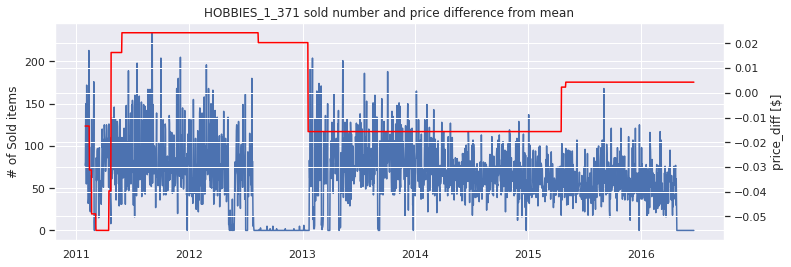

In [91]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(temp_df)
ax1.set_ylabel("# of Sold items")
ax2 = ax1.twinx()  
ax2.plot(df[(df["item_id"] == "HOBBIES_1_371") & (df["store_id"] == "CA_3")]["date"],
         df[df["item_id"] == "HOBBIES_1_371"].groupby("date")["sell_price_diff"].mean(), color="red")
ax2.set_ylabel("price_diff [\$]") 
plt.title("HOBBIES_1_371 sold number and price difference from mean")

이전의 FOOD 상품 결과에 비교하면, 이 상품은 판매 가격의 더 낮은 변동성을 갖고 있다.  
그리고 판매 상품의 수 또한 더 낮은 변동성이다.
(FOOD 상품의 경우, 최고 시즌에 평소보다 약 2.5배 더 많았다.)

다시, 2012년 하반기에 일부 판매되지 않은 기간이 있다는 것을 알았다.
모든 상품이 판매되지 않은 이런 기간이 있을까?

<!--
Compared to the previous FOOD item result, this item has lower volatility of sell price.   
And the number of sold items has also lower volatility.  
(In the FOOD item, we have around 2.5 times as much as usual sell on the top season)  

Again, we see some non sold period in the latter half of 2012.  
Does all item have these kinds of non-sold period?
-->

## Relationship of Lag Variables

In [92]:
df["lag_1"] = df.groupby("id")["value"].transform(lambda x: x.shift(1)).astype("float32")
df["lag_7"] = df.groupby("id")["value"].transform(lambda x: x.shift(7)).astype("float32")

In [93]:
# plt.figure(figsize=(8, 8))
# sns.pairplot(df[["cat_id", "value", "lag_1"]], hue="cat_id")

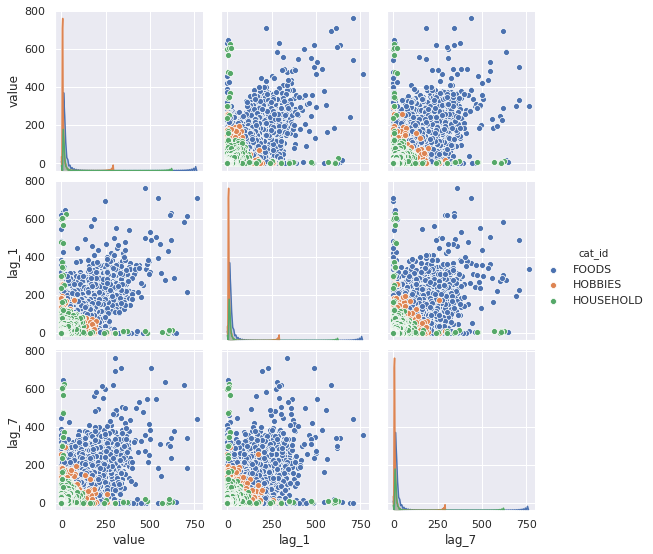

In [94]:
sns.pairplot(df[["cat_id", "value", "lag_1", "lag_7"]], hue="cat_id")

이런 경우에는 아마도 하루나 한 주의 지연 변수가 중요하다.
나의 다음 버전에서, 판매 날과 과거 며칠사이의 관계의 강점을 알아볼 것이다.

<!--
Maybe 1 day or 1 week lag variables are important in this case.  
I'll find the strength of correlation between the sold of the day and past few days in my next version.
-->

## PCA Trial

In [95]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [96]:
pca = PCA()

In [97]:
temp_df = df.loc[df["date"] >= "2015-01-01", ["sell_price", "dept_id", "value", "state_id", "cat_id"]]

In [98]:
# For memory usage reduction
del df
gc.collect()

493

In [99]:
temp_df.loc[temp_df["cat_id"] == "HOBBIES", "cat_color"]  = "orange"
temp_df.loc[temp_df["cat_id"] == "FOODS", "cat_color"]  = "blue"
temp_df.loc[temp_df["cat_id"] == "HOUSEHOLD", "cat_color"]  = "green"
color = temp_df["cat_color"]

In [100]:
le = LabelEncoder()
temp_df["enc_state_id"] = le.fit_transform(temp_df["state_id"])
temp_df.drop(columns=["state_id", "cat_id", "cat_color"], inplace=True)

In [101]:
# temp_df = temp_df.apply(lambda x: (x-x.mean()/ x.std(), axis=0))

In [102]:
pca.fit(temp_df)
feature = pca.transform(temp_df)

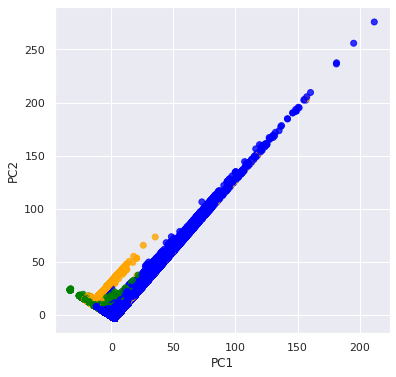

In [103]:
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=color)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [104]:
del temp_df
gc.collect()

2272

# Summary
   이 노트북에서, 몇몇의 쉬운 데이터 시각화를 통해 아래와 같은 데이터셋에 관한 몇몇 요소를 알 수 있었다.
   1. 각 카테고리에서 모든 상품의 판매 변화
      - 몇몇의 주기적인 영향 (주간과 월간)
      - 크리스마스에 거의 판매가 없다.
   2. 어떤 카테고리가 가장 많이 팔렸나?
      - FOODS가 이 3개의 카테고리에서 가장 많이 상품이 팔렸다.
      - HOUSEHOLD 카테고리가 두번째이고, HOBBIES가 가장 적게 팔린 것이다.
   3. 어떤 날이 가장 많이 팔렸나?
      - 토요일과 일요일이 가장 많은 상품이 판매된 날이다.
      - 반대로, 화요일 같은 평일이 가장 적게 팔린 날이다.
   4. 각 주마다 모든 상점에서 이동
      - CA에서 CA_3 상점이 가장 많이 팔린 상점이다.
      - 다른 주에서 그렇게 많은 차이가 나타나지 않았다.
      - 이런 판매 이동은 종종 등록된 상품 항목과 연관이 있다.
   5. Snap 구매가 가능한 날의 시각화
      - 전체 년에 Snap 구매가 가능한 날의 총 수는 2011년 부터 거의 같다.
      - 한달 동안 Snap 구매가 가능한 날의 총 수는 매달 10일이다.
      - 각 일별로 Snap 구매가 가능한 날의 총 수는 동등하게 분포되어 있다.
      - 그러나 Snap 구매가 가능한 flag를 따르면, 편향된 패턴이 있다.
        (예, 규칙적으로 3일 후에 하루같지는 않으나, 한주의 모든 날이거나 다음 주에 없거나 처럼은 있다.)
        
   그리고 마지막으로 히트맵을 사용해서 몇 개의 요소를 시각화한다.

<!--
   In this notebook, through some easy data visualization, we found some points regarding this dataset like below.
   1. The transition of all items sold in each category 
      - Some periodical effect. (Weekly and monthly)
      - On christmas day, there are almost no sales
   2. Which category is the most sold one?  
      - FOODS is the most sold item category of these three categories.
      - HOUSEHOLD category is the 2nd one, and the HOBBIES are the least sold one.
   3. Which day type is the most sold day? 
      - Saturday and Sunday is the most item sold day types.
      - In contrast, on weekdays like Tuesday, there are less item sold.
   4. The transition in all stores by each state
      - In CA, CA_3 store is the most sold store.  
      - In other states, not so much difference appeared.  
      - These sales trasition often corresponds to the registered item entries.
   5. Snap purchase allowed day visuaizaiton
      - The total count of Snap purchase allowed day in whole year is almost the same from 2011.
      - The total count of Snap purchase allowed day in one month is 10 in every month.
      - The total count of Snap purchase allowed day in each day type is almost uniformly distributed.
      - However, there are some biased patterns regarding snap purchase allowed flag.
        (i.e. it is not like one day in three consective days regularly, but all days in one week and none in next week)
    
   And finally we visualize some points by using heatmap.
-->

# Future Work
If I have time, I'd like to tackle with the following things.

1. Apply Dynamic Analysis and find out the relationship among state and stores.
2. Make One item or one store prediction model for beginners like me to learn how to use lightgbm as a regressor.
3. Check out the pre-processing effect. Is that effective considering the noise samples like Christmas or other irregularly days.
4. More detailed analysis and find out some useful information for making prediction.

# References
Following notebooks are the great notebooks in this competition. 
For whom hasn't check these notebooks, I strongly recommend you to take a look at these notebooks.
(I'm sorry if I missed some other great kernels, I'll take a lookt at other notebooks if I have enough time.)

Data Visualization:

- **M5 Forecasting - Starter Data Exploration**  
  https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration  

-  **Back to (predict) the future - Interactive M5 EDA**  
   https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

Making Prediction:

- **M5 - Three shades of Dark: Darker magic**  
  https://www.kaggle.com/kyakovlev/m5-three-shades-of-dark-darker-magic

-  **Very fst Model**  
   https://www.kaggle.com/ragnar123/very-fst-model

# Acknowledgment

I apologize that my english are somewhat wrong and my codes are not so beautiful one like others' codes.  
However, I tried hard to make simle codes as much as I can especially for beginners like me to learn how to use matplotlib and seaborn to do data visualization.  
Any comments or upvotes can be my very strong motivation towards much harder work! Thank you!